# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler
import plotter

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Constants

In [4]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=False, processed=True, enhanced=True)


Loading dataset: 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


# Methods

In [5]:
def count_wrong_timestamps(dataframe: pd.DataFrame):
    datetime_columns = [
        "time_call_received", "time_call_processed", "time_ambulance_notified",
        "time_dispatch", "time_arrival_scene", "time_departure_scene",
        "time_arrival_hospital", "time_available"
    ]

    # Count violations for each pair of datetime columns
    for i in range(len(datetime_columns) - 1):
        first_col = datetime_columns[i]
        second_col = datetime_columns[i + 1]
        
        # Count where the first date is after the second date
        count = dataframe[dataframe[first_col] > dataframe[second_col]].shape[0]
        print(f"{first_col} to {second_col}: {count}")


In [6]:
def find_first_problematic_row(dataframe: pd.DataFrame):
    # Convert columns to datetime if they're not already
    dataframe['time_call_received'] = pd.to_datetime(dataframe['time_call_received'])
    dataframe['time_call_processed'] = pd.to_datetime(dataframe['time_call_processed'])

    # Find the first row where time_call_received is after time_call_processed
    problematic_rows = dataframe[dataframe['time_call_received'] > dataframe['time_call_processed']]
    if not problematic_rows.empty:
        first_problematic_index = problematic_rows.index[0]
        print(f"First problematic row index: {first_problematic_index}")
        return first_problematic_index
    else:
        print("No problematic rows found.")
        return None


# Main

In [7]:
count_wrong_timestamps(data_loader.processed_incidents_df)


time_call_received to time_call_processed: 69721
time_call_processed to time_ambulance_notified: 7688
time_ambulance_notified to time_dispatch: 13
time_dispatch to time_arrival_scene: 34
time_arrival_scene to time_departure_scene: 2
time_departure_scene to time_arrival_hospital: 2
time_arrival_hospital to time_available: 34


In [8]:
dataframe = data_preprocessor._remove_duplicates(data_loader.processed_incidents_df)
dataframe = data_preprocessor._remove_incomplete_years(dataframe)
dataframe = data_preprocessor._remove_outside_region(dataframe)
dataframe = data_preprocessor._remove_other_resource_types(dataframe)
dataframe = data_preprocessor._count_resources_sent(dataframe)
dataframe = data_preprocessor._remove_extra_resources(dataframe)

dataframe = dataframe.sort_values(by="time_call_received")


In [9]:
count_wrong_timestamps(dataframe)


time_call_received to time_call_processed: 29433
time_call_processed to time_ambulance_notified: 2496
time_ambulance_notified to time_dispatch: 5
time_dispatch to time_arrival_scene: 17
time_arrival_scene to time_departure_scene: 0
time_departure_scene to time_arrival_hospital: 0
time_arrival_hospital to time_available: 6


In [10]:
dataframe["triage_impression_during_call"].value_counts()


triage_impression_during_call
H     145959
A     137909
V1     41852
V2     32787
V         14
Name: count, dtype: int64

In [11]:
dataframe = data_preprocessor._remove_other_triage_impressions(dataframe)


In [12]:
print(dataframe["triage_impression_during_call"].value_counts())

dataframe.info()


triage_impression_during_call
H     145959
A     137909
V1     41852
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 325726 entries, 147884 to 728620
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   triage_impression_during_call  325720 non-null  object        
 1   resource_id                    325726 non-null  object        
 2   resource_type                  325726 non-null  object        
 3   resources_sent                 325726 non-null  int64         
 4   time_call_received             325726 non-null  datetime64[ns]
 5   time_call_processed            325726 non-null  datetime64[ns]
 6   time_ambulance_notified        325616 non-null  datetime64[ns]
 7   time_dispatch                  322812 non-null  datetime64[ns]
 8   time_arrival_scene             301055 non-null  datetime64[ns]
 9   time_departure_scene           255399 non

In [13]:
count_wrong_timestamps(dataframe)


time_call_received to time_call_processed: 2372
time_call_processed to time_ambulance_notified: 2483
time_ambulance_notified to time_dispatch: 4
time_dispatch to time_arrival_scene: 14
time_arrival_scene to time_departure_scene: 0
time_departure_scene to time_arrival_hospital: 0
time_arrival_hospital to time_available: 4


In [14]:
dataframe = data_preprocessor._remove_wrong_timestamps(dataframe)


In [15]:
dataframe["triage_impression_during_call"].value_counts()


triage_impression_during_call
H     145320
A     136151
V1     41744
Name: count, dtype: int64

In [16]:
count_wrong_timestamps(dataframe)


time_call_received to time_call_processed: 2372
time_call_processed to time_ambulance_notified: 0
time_ambulance_notified to time_dispatch: 0
time_dispatch to time_arrival_scene: 0
time_arrival_scene to time_departure_scene: 0
time_departure_scene to time_arrival_hospital: 0
time_arrival_hospital to time_available: 0


In [17]:
dataframe = data_preprocessor._fix_timestamps(dataframe)


In [18]:
count_wrong_timestamps(dataframe)


time_call_received to time_call_processed: 0
time_call_processed to time_ambulance_notified: 0
time_ambulance_notified to time_dispatch: 0
time_dispatch to time_arrival_scene: 0
time_arrival_scene to time_departure_scene: 0
time_departure_scene to time_arrival_hospital: 0
time_arrival_hospital to time_available: 0


In [19]:
def drop_outside_bounds(dataframe: pd.DataFrame, column_start: str, column_end: str, lower_bound: float = None, upper_bound: float = None) -> pd.DataFrame:
    """
    Drops rows from the DataFrame where the time difference between two specified
    datetime columns is outside the given lower and/or upper bounds in seconds.

    Parameters:
    - dataframe: pd.DataFrame containing the data.
    - column_start: str, name of the start time column.
    - column_end: str, name of the end time column.
    - lower_bound: float, lower bound for the time difference in seconds. Default is None.
    - upper_bound: float, upper bound for the time difference in seconds. Default is None.

    Returns:
    - pd.DataFrame: Modified DataFrame with rows outside the bounds removed.
    """
    keep_mask = pd.Series(True, index=dataframe.index)

    valid_rows = dataframe[column_start].notnull() & dataframe[column_end].notnull()
    time_diffs = (dataframe.loc[valid_rows, column_end] - dataframe.loc[valid_rows, column_start]).dt.total_seconds()

    if lower_bound is not None:
        keep_mask.loc[valid_rows] = keep_mask.loc[valid_rows] & (time_diffs >= lower_bound).values
    if upper_bound is not None:
       keep_mask.loc[valid_rows] = keep_mask.loc[valid_rows] & (time_diffs <= upper_bound).values

    keep_mask = keep_mask.astype(bool)

    return dataframe[keep_mask]

In [20]:
data_loader.execute(clean=False, processed=True, enhanced=False)

dataframe = data_preprocessor._remove_duplicates(data_loader.processed_incidents_df)
dataframe = data_preprocessor._remove_incomplete_years(dataframe)
dataframe = data_preprocessor._remove_outside_region(dataframe)
dataframe = data_preprocessor._remove_other_resource_types(dataframe)
dataframe = data_preprocessor._count_resources_sent(dataframe)
dataframe = data_preprocessor._remove_extra_resources(dataframe)
dataframe = data_preprocessor._remove_other_triage_impressions(dataframe)
dataframe = data_preprocessor._remove_wrong_timestamps(dataframe)
dataframe = data_preprocessor._fix_timestamps(dataframe)
dataframe = data_preprocessor._remove_na(dataframe)


Loading dataset: 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]


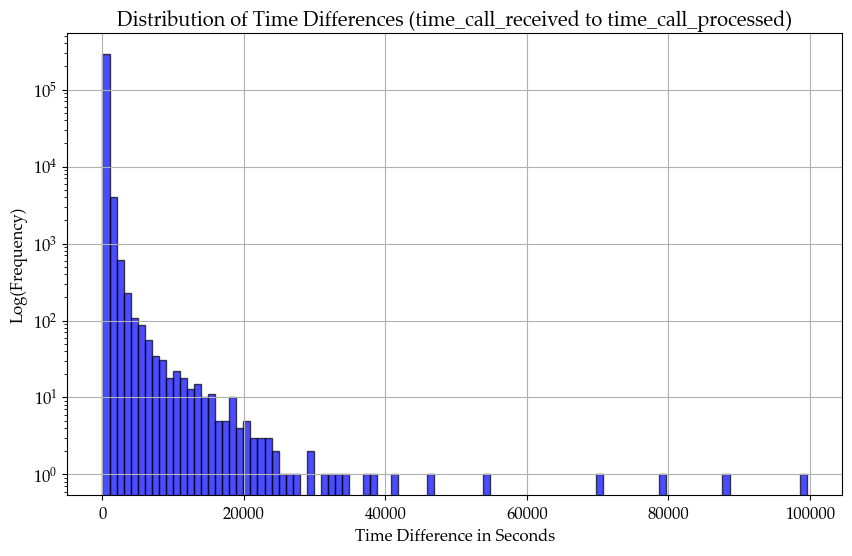

Mean time difference: 183.60562373354622 seconds
Median time difference: 95.0 seconds
Standard deviation of time difference: 602.1695433930106 seconds
Maximum time difference: 99595.0 seconds
Minimum time difference: 0.0 seconds
Suggested upper bound for dropping rows: 567.0 seconds
Suggested lower bound for dropping rows: 0 seconds


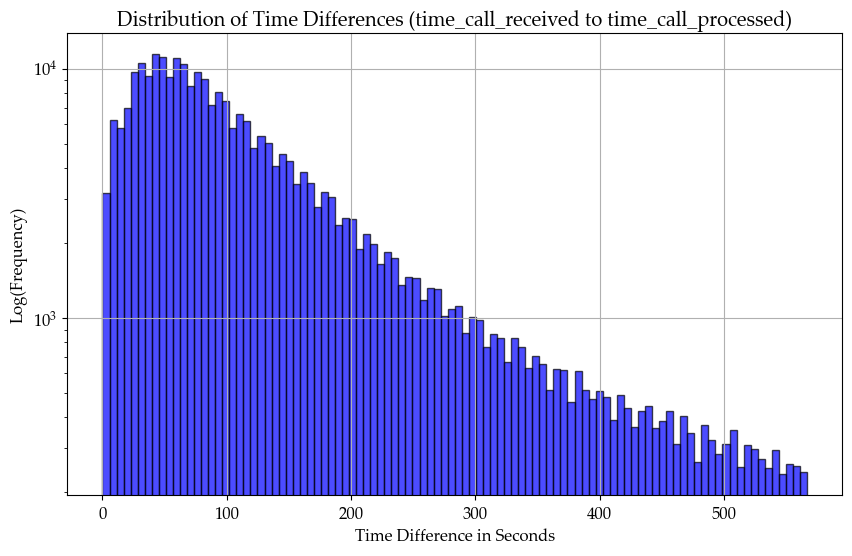

Mean time difference: 122.85133179778057 seconds
Median time difference: 89.0 seconds
Standard deviation of time difference: 107.67561791938078 seconds
Maximum time difference: 567.0 seconds
Minimum time difference: 0.0 seconds
Suggested upper bound for dropping rows: 326.5 seconds
Suggested lower bound for dropping rows: 0 seconds


Dropped 15281 rows


In [21]:
lower_bound, upper_bound = plotter.plot_time_difference_distribution(dataframe, "time_call_received", "time_call_processed", log_scale=True, IQR_multiplier=3)

before_size = dataframe.shape[0]
dataframe = drop_outside_bounds(dataframe, "time_call_received", "time_call_processed", lower_bound, upper_bound)

plotter.plot_time_difference_distribution(dataframe, "time_call_received", "time_call_processed", log_scale=True)
print(f"\n\nDropped {before_size - dataframe.shape[0]} rows")


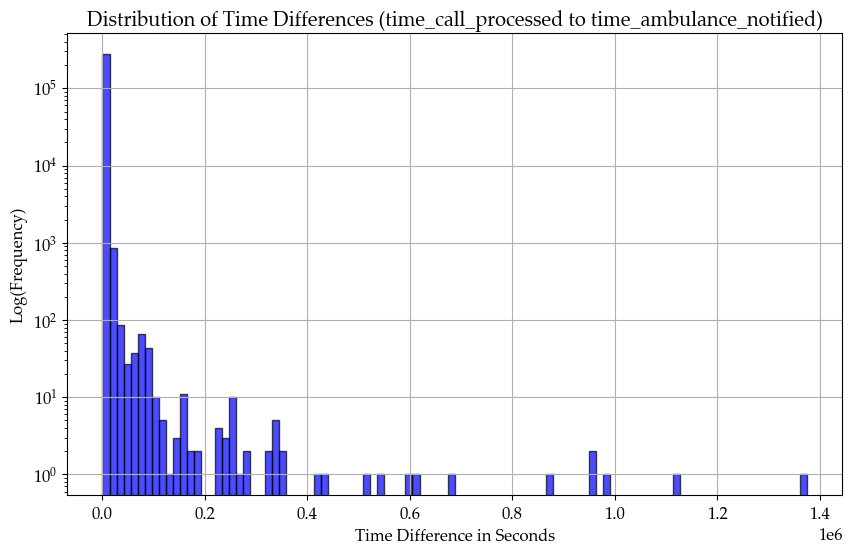

Mean time difference: 755.0813289176336 seconds
Median time difference: 76.0 seconds
Standard deviation of time difference: 7003.991106358116 seconds
Maximum time difference: 1375375.0 seconds
Minimum time difference: 0.0 seconds
Suggested upper bound for dropping rows: 1153.0 seconds
Suggested lower bound for dropping rows: 0 seconds


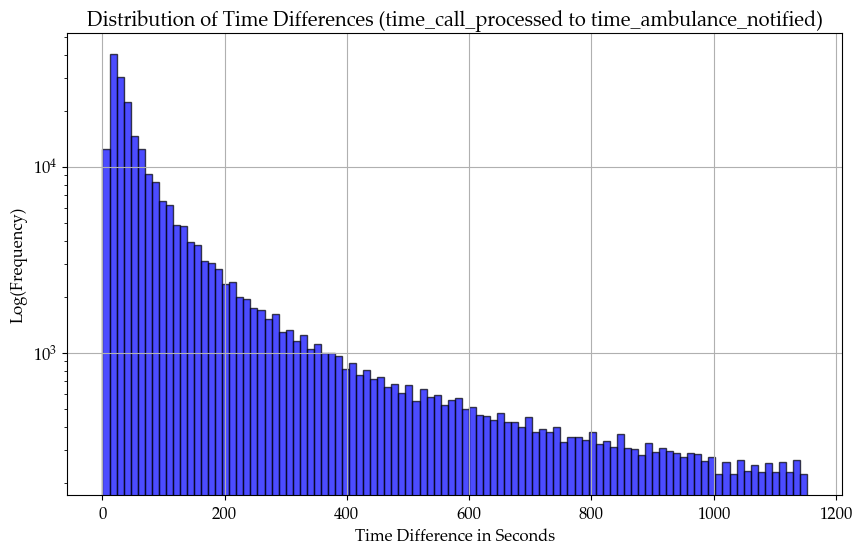

Mean time difference: 151.71689342872503 seconds
Median time difference: 58.0 seconds
Standard deviation of time difference: 220.2797184720936 seconds
Maximum time difference: 1153.0 seconds
Minimum time difference: 0.0 seconds
Suggested upper bound for dropping rows: 376.0 seconds
Suggested lower bound for dropping rows: 0 seconds


Dropped 33873 rows


In [22]:
lower_bound, upper_bound = plotter.plot_time_difference_distribution(dataframe, "time_call_processed", "time_ambulance_notified", log_scale=True, IQR_multiplier=3)

before_size = dataframe.shape[0]
dataframe = drop_outside_bounds(dataframe, "time_call_processed", "time_ambulance_notified", lower_bound, upper_bound)

plotter.plot_time_difference_distribution(dataframe, "time_call_processed", "time_ambulance_notified", log_scale=True)
print(f"\n\nDropped {before_size - dataframe.shape[0]} rows")


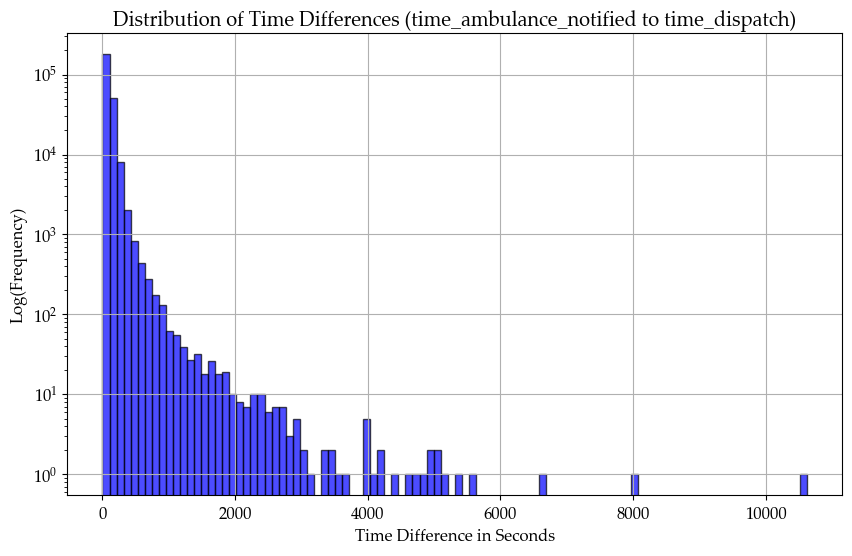

Mean time difference: 80.97396716430255 seconds
Median time difference: 68.0 seconds
Standard deviation of time difference: 114.9657325333638 seconds
Maximum time difference: 10626.0 seconds
Minimum time difference: 0.0 seconds
Suggested upper bound for dropping rows: 407.0 seconds
Suggested lower bound for dropping rows: 0 seconds


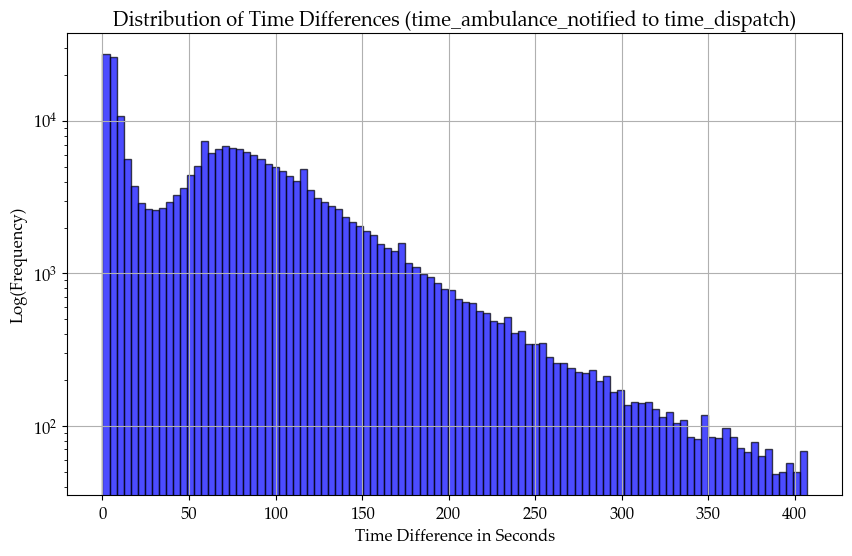

Mean time difference: 73.91131407752184 seconds
Median time difference: 67.0 seconds
Standard deviation of time difference: 67.09069615305678 seconds
Maximum time difference: 407.0 seconds
Minimum time difference: 0.0 seconds
Suggested upper bound for dropping rows: 255.0 seconds
Suggested lower bound for dropping rows: 0 seconds


Dropped 2471 rows


In [23]:
lower_bound, upper_bound = plotter.plot_time_difference_distribution(dataframe, "time_ambulance_notified", "time_dispatch", log_scale=True, IQR_multiplier=3)

before_size = dataframe.shape[0]
dataframe = drop_outside_bounds(dataframe, "time_ambulance_notified", "time_dispatch", lower_bound, upper_bound)

plotter.plot_time_difference_distribution(dataframe, "time_ambulance_notified", "time_dispatch", log_scale=True)
print(f"\n\nDropped {before_size - dataframe.shape[0]} rows")


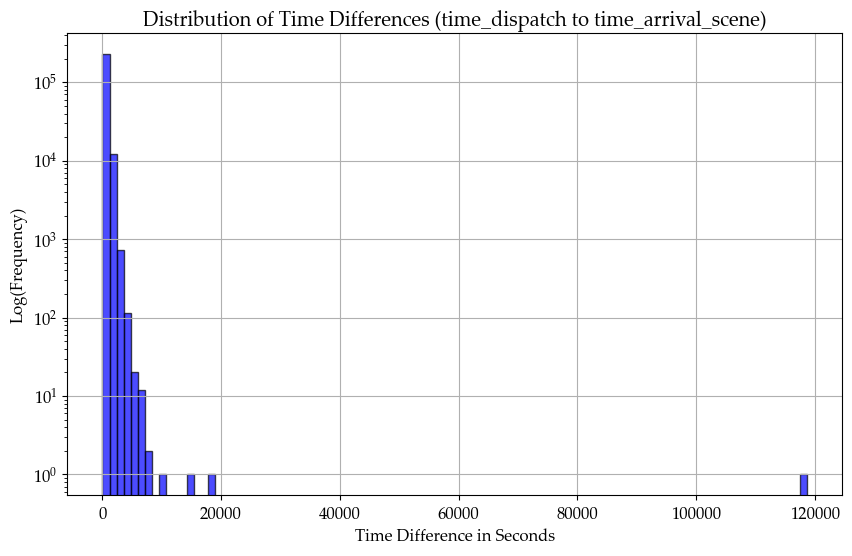

Mean time difference: 525.0231387279131 seconds
Median time difference: 443.0 seconds
Standard deviation of time difference: 455.8457550675961 seconds
Maximum time difference: 118709.0 seconds
Minimum time difference: 0.0 seconds
Suggested upper bound for dropping rows: 1861.0 seconds
Suggested lower bound for dropping rows: 0 seconds


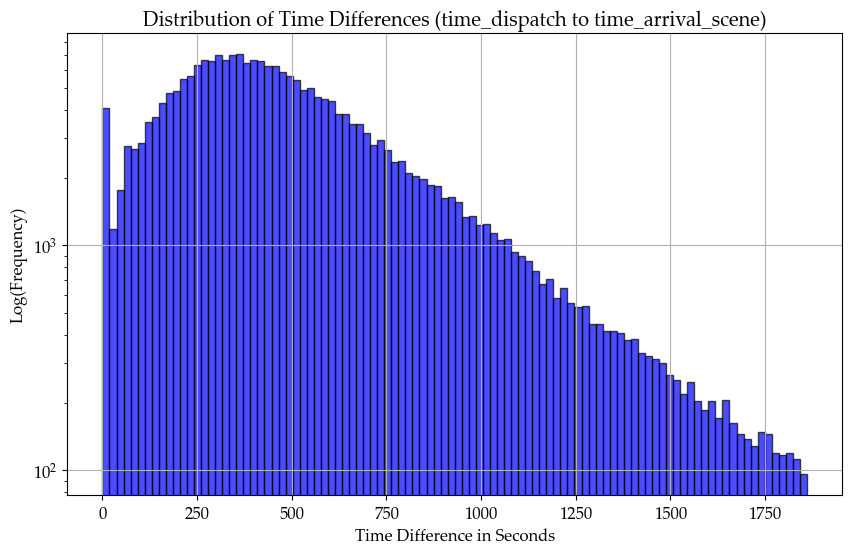

Mean time difference: 504.95832735376797 seconds
Median time difference: 439.0 seconds
Standard deviation of time difference: 326.5310991187805 seconds
Maximum time difference: 1861.0 seconds
Minimum time difference: 0.0 seconds
Suggested upper bound for dropping rows: 1243.5 seconds
Suggested lower bound for dropping rows: 0 seconds


Dropped 2421 rows


In [24]:
lower_bound, upper_bound = plotter.plot_time_difference_distribution(dataframe, "time_dispatch", "time_arrival_scene", log_scale=True, IQR_multiplier=3)

before_size = dataframe.shape[0]
dataframe = drop_outside_bounds(dataframe, "time_dispatch", "time_arrival_scene", lower_bound, upper_bound)

plotter.plot_time_difference_distribution(dataframe, "time_dispatch", "time_arrival_scene", log_scale=True)
print(f"\n\nDropped {before_size - dataframe.shape[0]} rows")


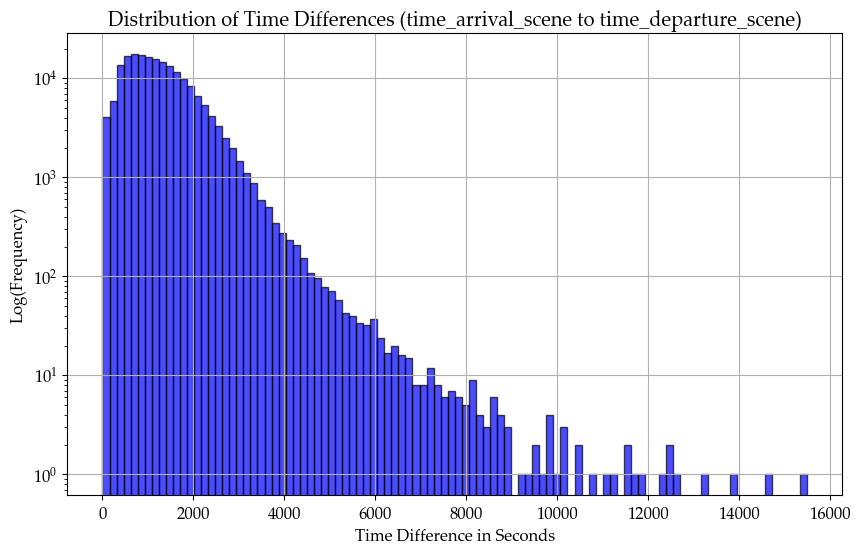

Mean time difference: 1280.6585739841553 seconds
Median time difference: 1146.0 seconds
Standard deviation of time difference: 803.1348096586152 seconds
Maximum time difference: 15502.0 seconds
Minimum time difference: 0.0 seconds
Suggested upper bound for dropping rows: 4717.0 seconds
Suggested lower bound for dropping rows: 0 seconds


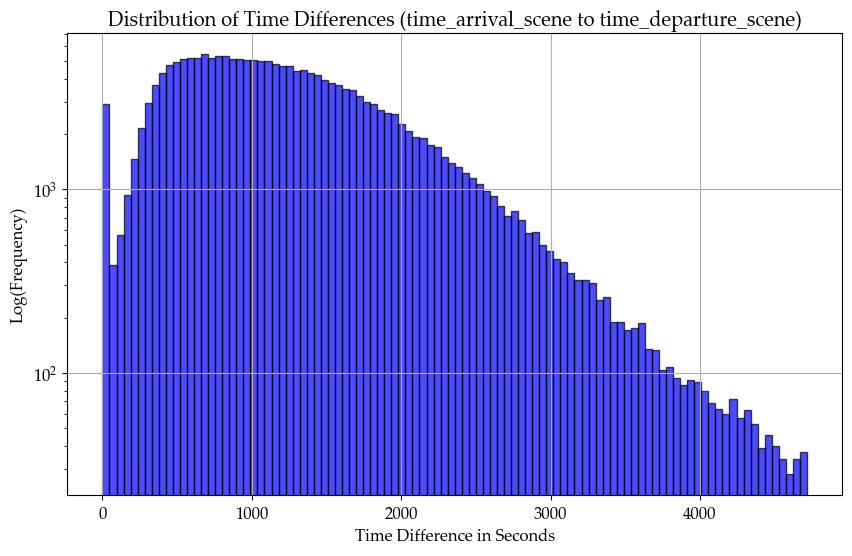

Mean time difference: 1264.7827915301261 seconds
Median time difference: 1143.0 seconds
Standard deviation of time difference: 750.9698792149173 seconds
Maximum time difference: 4717.0 seconds
Minimum time difference: 0.0 seconds
Suggested upper bound for dropping rows: 3195.0 seconds
Suggested lower bound for dropping rows: 0 seconds


Dropped 653 rows


In [25]:
lower_bound, upper_bound = plotter.plot_time_difference_distribution(dataframe, "time_arrival_scene", "time_departure_scene", log_scale=True, IQR_multiplier=3)

before_size = dataframe.shape[0]
dataframe = drop_outside_bounds(dataframe, "time_arrival_scene", "time_departure_scene", lower_bound, upper_bound)

plotter.plot_time_difference_distribution(dataframe, "time_arrival_scene", "time_departure_scene", log_scale=True)
print(f"\n\nDropped {before_size - dataframe.shape[0]} rows")


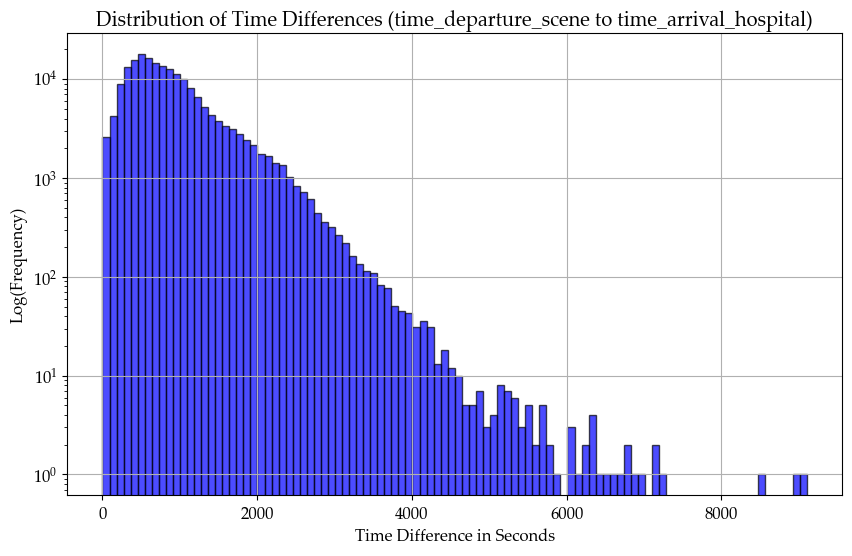

Mean time difference: 899.759057831659 seconds
Median time difference: 755.0 seconds
Standard deviation of time difference: 606.7151828137734 seconds
Maximum time difference: 9108.0 seconds
Minimum time difference: 0.0 seconds
Suggested upper bound for dropping rows: 3169.0 seconds
Suggested lower bound for dropping rows: 0 seconds


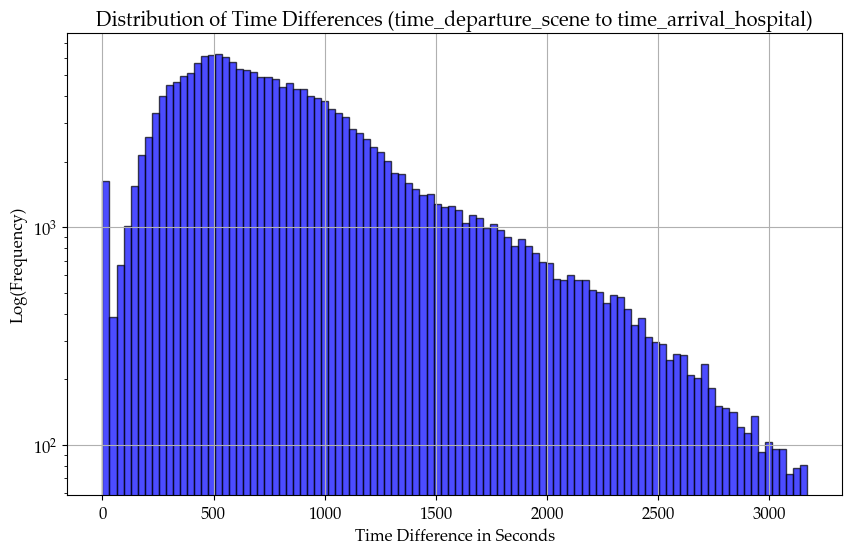

Mean time difference: 883.502323446437 seconds
Median time difference: 752.0 seconds
Standard deviation of time difference: 566.3615680862397 seconds
Maximum time difference: 3169.0 seconds
Minimum time difference: 0.0 seconds
Suggested upper bound for dropping rows: 2138.5 seconds
Suggested lower bound for dropping rows: 0 seconds


Dropped 1104 rows


In [26]:
lower_bound, upper_bound = plotter.plot_time_difference_distribution(dataframe, "time_departure_scene", "time_arrival_hospital", log_scale=True, IQR_multiplier=3)

before_size = dataframe.shape[0]
dataframe = drop_outside_bounds(dataframe, "time_departure_scene", "time_arrival_hospital", lower_bound, upper_bound)

plotter.plot_time_difference_distribution(dataframe, "time_departure_scene", "time_arrival_hospital", log_scale=True)
print(f"\n\nDropped {before_size - dataframe.shape[0]} rows")


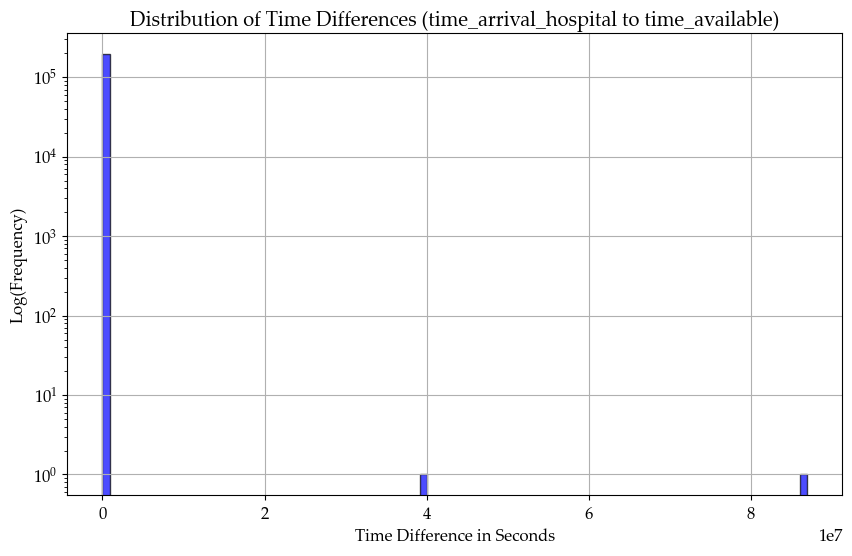

Mean time difference: 1743.6435817693264 seconds
Median time difference: 896.0 seconds
Standard deviation of time difference: 216650.86924696882 seconds
Maximum time difference: 86919844.0 seconds
Minimum time difference: 0.0 seconds
Suggested upper bound for dropping rows: 3295.0 seconds
Suggested lower bound for dropping rows: 0 seconds


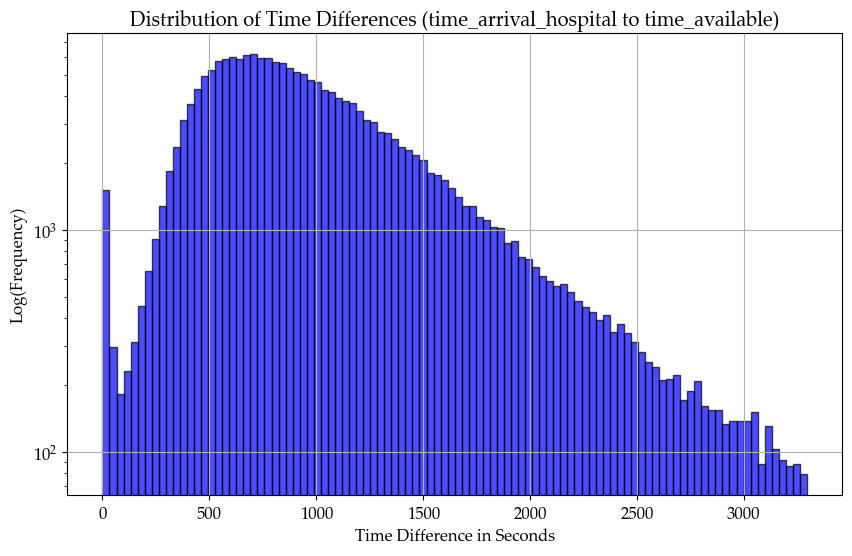

Mean time difference: 1003.2555550323597 seconds
Median time difference: 888.0 seconds
Standard deviation of time difference: 540.6520521615256 seconds
Maximum time difference: 3295.0 seconds
Minimum time difference: 0.0 seconds
Suggested upper bound for dropping rows: 2240.0 seconds
Suggested lower bound for dropping rows: 0 seconds


Dropped 2760 rows


In [27]:
lower_bound, upper_bound = plotter.plot_time_difference_distribution(dataframe, "time_arrival_hospital", "time_available", log_scale=True, IQR_multiplier=3)

before_size = dataframe.shape[0]
dataframe = drop_outside_bounds(dataframe, "time_arrival_hospital", "time_available", lower_bound, upper_bound)

plotter.plot_time_difference_distribution(dataframe, "time_arrival_hospital", "time_available", log_scale=True)
print(f"\n\nDropped {before_size - dataframe.shape[0]} rows")


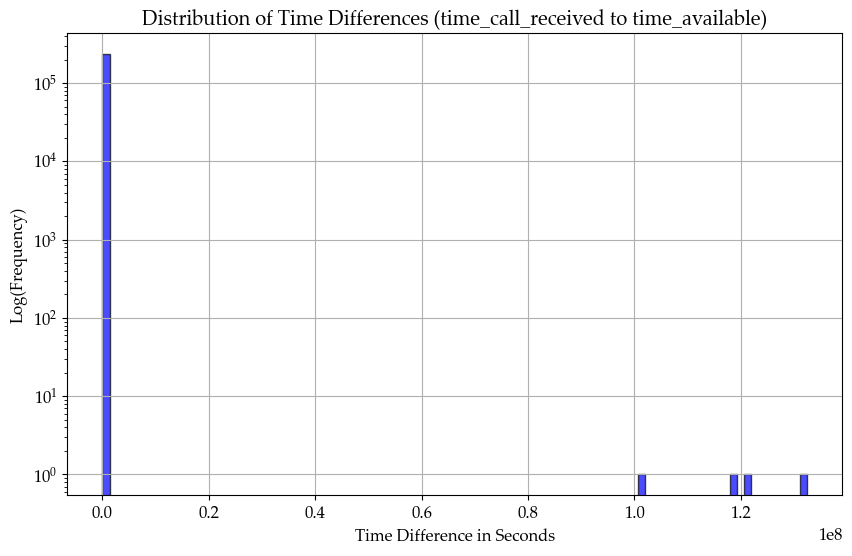

Mean time difference: 5836.282101793561 seconds
Median time difference: 3693.0 seconds
Standard deviation of time difference: 492762.7600690626 seconds
Maximum time difference: 132452289.0 seconds
Minimum time difference: 18.0 seconds
Suggested upper bound for dropping rows: 10090.0 seconds
Suggested lower bound for dropping rows: 0 seconds


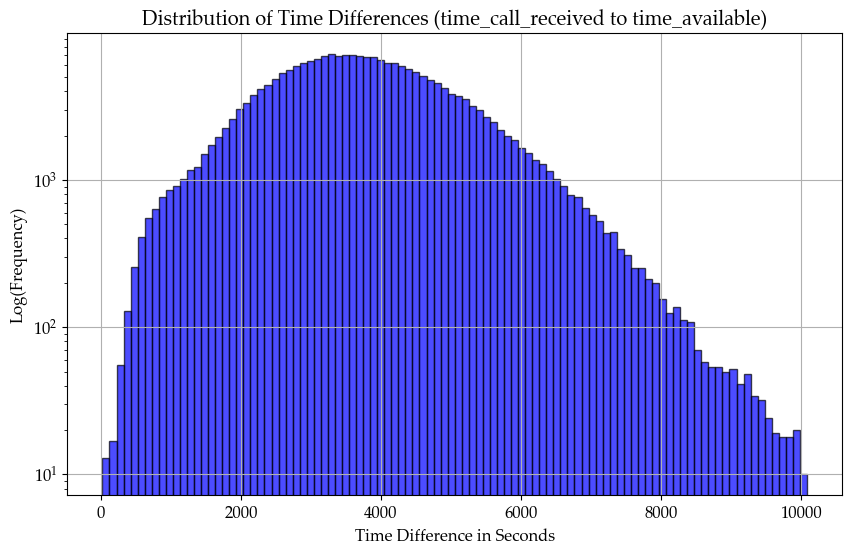

Mean time difference: 3788.664446423532 seconds
Median time difference: 3691.0 seconds
Standard deviation of time difference: 1393.8033779578138 seconds
Maximum time difference: 10088.0 seconds
Minimum time difference: 18.0 seconds
Suggested upper bound for dropping rows: 7363.0 seconds
Suggested lower bound for dropping rows: 115.0 seconds


Dropped 233 rows


In [28]:
lower_bound, upper_bound = plotter.plot_time_difference_distribution(dataframe, "time_call_received", "time_available", log_scale=True, IQR_multiplier=3)

before_size = dataframe.shape[0]
dataframe = drop_outside_bounds(dataframe, "time_call_received", "time_available", lower_bound, upper_bound)

plotter.plot_time_difference_distribution(dataframe, "time_call_received", "time_available", log_scale=True)
print(f"\n\nDropped {before_size - dataframe.shape[0]} rows")


In [29]:
dataframe.info()


<class 'pandas.core.frame.DataFrame'>
Index: 232168 entries, 147884 to 728620
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   triage_impression_during_call  232168 non-null  object        
 1   resource_id                    232168 non-null  object        
 2   resource_type                  232168 non-null  object        
 3   resources_sent                 232168 non-null  int64         
 4   time_call_received             232168 non-null  datetime64[ns]
 5   time_call_processed            232168 non-null  datetime64[ns]
 6   time_ambulance_notified        232168 non-null  datetime64[ns]
 7   time_dispatch                  232168 non-null  datetime64[ns]
 8   time_arrival_scene             232168 non-null  datetime64[ns]
 9   time_departure_scene           191110 non-null  datetime64[ns]
 10  time_arrival_hospital          191110 non-null  datetime64[ns]
 11  